# Simple TEMPO O3 Prediction Model


### Uses a simple CNN autoencoder instead of ConvLSTM - much more robust for limited data.


In [44]:
# Imports
import os
import glob
import pickle
import numpy as np
import netCDF4 as nc
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.20.0


In [58]:
# Settings
DATA_FOLDER = '/AEPG-Network-NASA-Universal-Event-/data/'
OUTPUT_FOLDER = 'models'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Downsample size
TARGET_H = 64
TARGET_W = 512

# Training
BATCH_SIZE = 4
EPOCHS = 50

# Variable names
O3_VAR = 'column_amount_o3'
QUALITY_VAR = 'quality_flag'

In [46]:
# Find files
nc_files = sorted(glob.glob(os.path.join(DATA_FOLDER, '*.nc')))
print(f'Found {len(nc_files)} .nc files')
if len(nc_files) == 0:
    raise FileNotFoundError(f'No .nc files in {DATA_FOLDER}')

Found 1 .nc files


In [47]:
# Read TEMPO file
def read_tempo_o3(path):
    """Read O3 data from TEMPO file"""
    try:
        root = nc.Dataset(path, mode='r')
        prod = root.groups.get('product') or root.groups.get('PRODUCT')
        if prod is None:
            raise KeyError('No product group found')
        
        o3 = np.array(prod.variables[O3_VAR][:], dtype=float)
        
        # Apply quality filter if available
        if QUALITY_VAR in prod.variables:
            qual = np.array(prod.variables[QUALITY_VAR][:])
            o3 = np.where(qual == 0, o3, np.nan)
        
        root.close()
        return o3
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None

In [48]:
# Load and preprocess all files
frames = []
for path in nc_files:
    arr = read_tempo_o3(path)
    if arr is None or arr.ndim != 2:
        continue
    
    # Replace NaNs with mean
    arr = np.nan_to_num(arr, nan=np.nanmean(arr))
    
    # Resize
    arr_resized = resize(arr, (TARGET_H, TARGET_W), preserve_range=True, anti_aliasing=True)
    frames.append(arr_resized.astype(np.float32))

if len(frames) == 0:
    raise ValueError('No valid frames loaded')

frames = np.array(frames)
print(f'Loaded {len(frames)} frames, shape: {frames.shape}')

Loaded 1 frames, shape: (1, 64, 512)


In [49]:
# Data augmentation - create more samples
print('\nApplying augmentation...')
augmented = []

for frame in frames:
    # Original
    augmented.append(frame)
    
    # Flipped
    augmented.append(np.fliplr(frame))
    
    # Noisy variations
    for scale in [0.01, 0.02, 0.03]:
        noise = np.random.normal(0, np.mean(np.abs(frame)) * scale, frame.shape)
        augmented.append(frame + noise)
    
    # Scaled variations
    for scale in [0.95, 0.97, 1.03, 1.05]:
        augmented.append(frame * scale)

X_train = np.array(augmented)
print(f'Augmented: {len(frames)} → {len(X_train)} samples')
print(f'Shape: {X_train.shape}')


Applying augmentation...
Augmented: 1 → 9 samples
Shape: (9, 64, 512)


In [50]:
# Normalize
mean_val = np.mean(X_train)
std_val = np.std(X_train)
X_train_norm = (X_train - mean_val) / std_val

# Add channel dimension
X_train_norm = X_train_norm[..., np.newaxis]
print(f'Normalized data shape: {X_train_norm.shape}')

Normalized data shape: (9, 64, 512, 1)


In [51]:
# Build simple autoencoder model
def build_model(input_shape=(TARGET_H, TARGET_W, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    out = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()

2025-10-05 23:22:52.172066: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 512, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 512, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 256, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 256, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 128, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 256, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 256, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 512, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 512, 1)     │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train (autoencoder trains on itself)
history = model.fit(
    X_train_norm, X_train_norm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.7855 - mae: 0.6406 - val_loss: 1.0520 - val_mae: 0.9308
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - loss: 0.6522 - mae: 0.5806 - val_loss: 0.6531 - val_mae: 0.7192
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step - loss: 0.4727 - mae: 0.4984 - val_loss: 0.3150 - val_mae: 0.4677
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - loss: 0.2904 - mae: 0.3868 - val_loss: 0.2417 - val_mae: 0.3873
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - loss: 0.3059 - mae: 0.3729 - val_loss: 0.1553 - val_mae: 0.2773
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - loss: 0.2935 - mae: 0.3862 - val_loss: 0.1311 - val_mae: 0.2369
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - loss: 0.2461 - mae: 0.3366 - val_loss: 0.1726 - val_mae: 0.3081
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - loss: 0.2291 - mae: 0.3278 - val_loss: 0.3741 - val_mae: 0.5163
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - loss: 0.2289 - mae: 0.3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


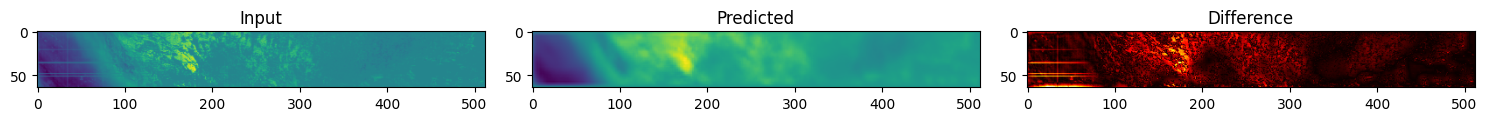

MSE: 10.801815


In [55]:
# Test prediction
test_idx = 0
test_input = X_train_norm[test_idx:test_idx+1]
prediction = model.predict(test_input)

# Denormalize
test_orig = test_input[0, ..., 0] * std_val + mean_val
pred_denorm = prediction[0, ..., 0] * std_val + mean_val

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(test_orig, cmap='viridis')
axes[0].set_title('Input')
# axes[0].colorbar()
axes[1].imshow(pred_denorm, cmap='viridis')
axes[1].set_title('Predicted')
# axes[1].colorbar()
axes[2].imshow(np.abs(test_orig - pred_denorm), cmap='hot')
axes[2].set_title('Difference')
# axes[2].colorbar()
plt.tight_layout()
plt.show()

mse = np.mean((test_orig - pred_denorm)**2)
print(f'MSE: {mse:.6f}')

In [56]:
# Save model and metadata
model_path = os.path.join(OUTPUT_FOLDER, 'tempo_o3_simple.h5')
model.save(model_path)

metadata = {
    'model_path': model_path,
    'target_h': TARGET_H,
    'target_w': TARGET_W,
    'mean': mean_val,
    'std': std_val,
    'num_files': len(nc_files),
    'num_samples': len(X_train)
}

with open(os.path.join(OUTPUT_FOLDER, 'tempo_o3_metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)

print(f'\n✅ Model saved to: {model_path}')
print(f'✅ Metadata saved to: {OUTPUT_FOLDER}/tempo_o3_metadata.pkl')


✅ Model saved to: models/tempo_o3_simple.h5
✅ Metadata saved to: models/tempo_o3_metadata.pkl


In [57]:
# Backend usage example
example_code = '''
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Load model and metadata
with open('models/tempo_o3_metadata.pkl', 'rb') as f:
    meta = pickle.load(f)

model = load_model(meta['model_path'])

# Prepare input frame
# input_frame = ... # Your (H, W) array
# input_resized = resize(input_frame, (meta['target_h'], meta['target_w']))
# input_norm = (input_resized - meta['mean']) / meta['std']
# input_tensor = input_norm[np.newaxis, ..., np.newaxis]

# Predict
# prediction = model.predict(input_tensor)
# output = prediction[0, ..., 0] * meta['std'] + meta['mean']
'''

print(example_code)


import pickle
import numpy as np
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Load model and metadata
with open('models/tempo_o3_metadata.pkl', 'rb') as f:
    meta = pickle.load(f)

model = load_model(meta['model_path'])

# Prepare input frame
# input_frame = ... # Your (H, W) array
# input_resized = resize(input_frame, (meta['target_h'], meta['target_w']))
# input_norm = (input_resized - meta['mean']) / meta['std']
# input_tensor = input_norm[np.newaxis, ..., np.newaxis]

# Predict
# prediction = model.predict(input_tensor)
# output = prediction[0, ..., 0] * meta['std'] + meta['mean']

